### Imputation con rete neurale (una feature alla volta)

In [14]:
import pandas as pd

dataset = pd.read_csv('../data/datiLussazioniDefinitivi.csv', delimiter=';')
dataset

,CASE_ID,BREED,GENDER_01,AGEATSURGERYmo,BODYWEIGHTKG,Taglia,BCS,INDICATIONFORTHR,HIPRL,YEAR,...,NECKSIZE,HEADSIZE,ALO,CUPRETROVERSION,STEMANTEVERSIONREAL,RECTUSFEMORISM.RELEASE,first_lux_days_after_thr,DIRECTION,LUX_01,LUX_CR
0,1,3,0,"56,5","31,6",1,5,4,R,2021,...,4,1,46.0,15,"17,7",NO,NaN,NaN,0,0
1,2,8,0,"9,4","40,9",1,5,4,L,2021,...,5,1,40.0,25,"27,7",NO,NaN,NaN,0,0
2,3,10,0,"15,1333333333333",35,1,5,4,R,2021,...,4,1,42.0,20,"27,7",YES,NaN,NaN,0,0
3,4,6,0,"83,4333333333333","18,7",0,6,4,L,2021,...,4,0,40.0,18,"24,2",NO,NaN,NaN,0,0
4,5,5,0,"7,53333333333333","36,4",1,4,4,L,2021,...,5,1,42.0,28,"25,9",YES,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,3193,3,0,"57,4333333333333",25,1,5,2,R,2010,...,3,0,43.0,32,"27,7",NO,35.0,CRANIO-DORSALE,1,1
3193,3194,5,1,"49,2333333333333",38,1,6,2,R,2009,...,4,0,48.0,26,"25,9",NO,18.0,CRANIO-DORSALE,1,1
3194,3195,13,0,"38,0333333333333",43,1,5,2,R,2008,...,4,0,48.0,4,"11,5",NO,30.0,CRANIO-DORSALE,1,1
3195,3196,5,1,"11,5333333333333",28,1,5,2,R,2001,...,4,0,52.0,10,"31,3",NO,26.0,CRANIO-DORSALE,1,1


In [15]:
import sys

sys.path.append('/home/biso/Tirocinio/tirocinio/base_lib')

In [16]:
import functions as func
import models
import imputation as imp 

In [17]:
def clean_dataset(dataset):
    """
    Pulisce il dataset applicando varie trasformazioni ai dati.

    Args:
        dataset (pd.DataFrame): Il dataset da pulire.

    Returns:
        pd.DataFrame: Il dataset pulito.
    """

    dataset.AGEATSURGERYmo = dataset.AGEATSURGERYmo.str.replace(',', '.').astype('float64')
    dataset.BODYWEIGHTKG = dataset.BODYWEIGHTKG.str.replace(',', '.').astype('float64')
    dataset.BCS = dataset.BCS.str.replace(',', '.').astype('float64')
    dataset.STEMANTEVERSIONREAL = dataset.STEMANTEVERSIONREAL.str.replace(',', '.').astype('float64')

    dataset['HIPRL'] = dataset.HIPRL.replace(['L', 'l'], 0)
    dataset['HIPRL'] = dataset.HIPRL.replace('R', 1)

    dataset['RECTUSFEMORISM.RELEASE'] = dataset['RECTUSFEMORISM.RELEASE'].replace(['NO', ' NO'], 0)
    dataset['RECTUSFEMORISM.RELEASE'] = dataset['RECTUSFEMORISM.RELEASE'].replace('YES', 1)
    dataset['RECTUSFEMORISM.RELEASE'] = dataset['RECTUSFEMORISM.RELEASE'].replace('PARTIAL', 2)

    valori = dataset.STEMSIZE.unique()
    count = 0
    for v in valori:
        dataset['STEMSIZE'] = dataset['STEMSIZE'].replace(v, count)
        count += 1

    dataset['DIRECTION'] = dataset['DIRECTION'].replace('CRANIO-DORSALE', 0)
    dataset['DIRECTION'] = dataset['DIRECTION'].replace('CAUDO-VENTRALE', 1)
    cols = ['n_luxation', 'first_lux_days_after_thr', 'DIRECTION']
    dataset[cols] = dataset[cols].fillna(-1)

    return dataset

In [42]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/datiLussazioniDefinitivi.csv", delimiter=';')
df = clean_dataset(df)

df_original = pd.read_csv("../data/datiLussazioniDefinitivi.csv", delimiter=';')
df_original = clean_dataset(df_original)

# 1. Sostituzione dei valori mancanti con -1 nelle colonne specifiche
df['n_luxation'].fillna(-1, inplace=True)
df['first_lux_days_after_thr'].fillna(-1, inplace=True)
df['DIRECTION'].fillna(-1, inplace=True)

# 2. Funzione per l'imputation di una singola feature con rete neurale
def impute_with_neural_network(df, feature, features_to_use, binary=False):
    # Separare le righe con e senza valori mancanti
    train_data = df[df[feature].notna()]
    missing_data = df[df[feature].isna()]
    
    # Selezionare le feature predittive
    X_train = train_data[features_to_use]
    y_train = train_data[feature]
    X_missing = missing_data[features_to_use]
    
    # Normalizzazione delle feature
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_missing_scaled = scaler.transform(X_missing)
    
    # Definizione e addestramento della rete neurale
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    if binary:
        model.add(Dense(1, activation='sigmoid'))  # Sigmoid per feature binarie
        loss_function = 'binary_crossentropy'
    else:
        model.add(Dense(1, activation='linear'))  # Linear per feature continue
        loss_function = 'mean_squared_error'
    model.compile(optimizer='adam', loss=loss_function)
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
    
    # Predizione e imputazione dei valori mancanti
    predicted_values = model.predict(X_missing_scaled)
    if binary:
        predicted_values = (predicted_values > 0.5).astype(int)  # Arrotondamento per valori binari
    df.loc[df[feature].isna(), feature] = predicted_values

# 3. Elenco delle feature da imputare e quelle predittive
features_to_impute = ['BCS', 'HIPRL', 'ALO', 'STEMANTEVERSIONREAL']
features_to_use = df.columns.difference(features_to_impute)

# 4. Imputation delle feature con rete neurale
for feature in features_to_impute:
    binary = feature == 'HIPRL'  # Gestione specifica per la feature binaria
    impute_with_neural_network(df, feature, features_to_use, binary=binary)

/home/biso/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/home/biso/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/biso/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/home/biso/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [43]:
df

,CASE_ID,BREED,GENDER_01,AGEATSURGERYmo,BODYWEIGHTKG,Taglia,BCS,INDICATIONFORTHR,HIPRL,YEAR,...,NECKSIZE,HEADSIZE,ALO,CUPRETROVERSION,STEMANTEVERSIONREAL,RECTUSFEMORISM.RELEASE,first_lux_days_after_thr,DIRECTION,LUX_01,LUX_CR
0,1,3,0,56.500000,31.6,1,5.0,4,1.0,2021,...,4,1,46.0,15,17.7,0,-1.0,-1.0,0,0
1,2,8,0,9.400000,40.9,1,5.0,4,0.0,2021,...,5,1,40.0,25,27.7,0,-1.0,-1.0,0,0
2,3,10,0,15.133333,35.0,1,5.0,4,1.0,2021,...,4,1,42.0,20,27.7,1,-1.0,-1.0,0,0
3,4,6,0,83.433333,18.7,0,6.0,4,0.0,2021,...,4,0,40.0,18,24.2,0,-1.0,-1.0,0,0
4,5,5,0,7.533333,36.4,1,4.0,4,0.0,2021,...,5,1,42.0,28,25.9,1,-1.0,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,3193,3,0,57.433333,25.0,1,5.0,2,1.0,2010,...,3,0,43.0,32,27.7,0,35.0,0.0,1,1
3193,3194,5,1,49.233333,38.0,1,6.0,2,1.0,2009,...,4,0,48.0,26,25.9,0,18.0,0.0,1,1
3194,3195,13,0,38.033333,43.0,1,5.0,2,1.0,2008,...,4,0,48.0,4,11.5,0,30.0,0.0,1,1
3195,3196,5,1,11.533333,28.0,1,5.0,2,1.0,2001,...,4,0,52.0,10,31.3,0,26.0,0.0,1,1


In [44]:
df_original.isna().sum()

CASE_ID                     0
BREED                       0
GENDER_01                   0
AGEATSURGERYmo              0
BODYWEIGHTKG                0
Taglia                      0
BCS                         2
INDICATIONFORTHR            0
HIPRL                       1
YEAR                        0
n_luxation                  0
GENERATION                  0
STEMSIZE                    0
CUPSIZE                     0
NECKSIZE                    0
HEADSIZE                    0
ALO                         1
CUPRETROVERSION             0
STEMANTEVERSIONREAL         1
RECTUSFEMORISM.RELEASE      0
first_lux_days_after_thr    0
DIRECTION                   0
LUX_01                      0
LUX_CR                      0
dtype: int64

In [45]:
df.isna().sum()

CASE_ID                     0
BREED                       0
GENDER_01                   0
AGEATSURGERYmo              0
BODYWEIGHTKG                0
Taglia                      0
BCS                         0
INDICATIONFORTHR            0
HIPRL                       0
YEAR                        0
n_luxation                  0
GENERATION                  0
STEMSIZE                    0
CUPSIZE                     0
NECKSIZE                    0
HEADSIZE                    0
ALO                         0
CUPRETROVERSION             0
STEMANTEVERSIONREAL         0
RECTUSFEMORISM.RELEASE      0
first_lux_days_after_thr    0
DIRECTION                   0
LUX_01                      0
LUX_CR                      0
dtype: int64

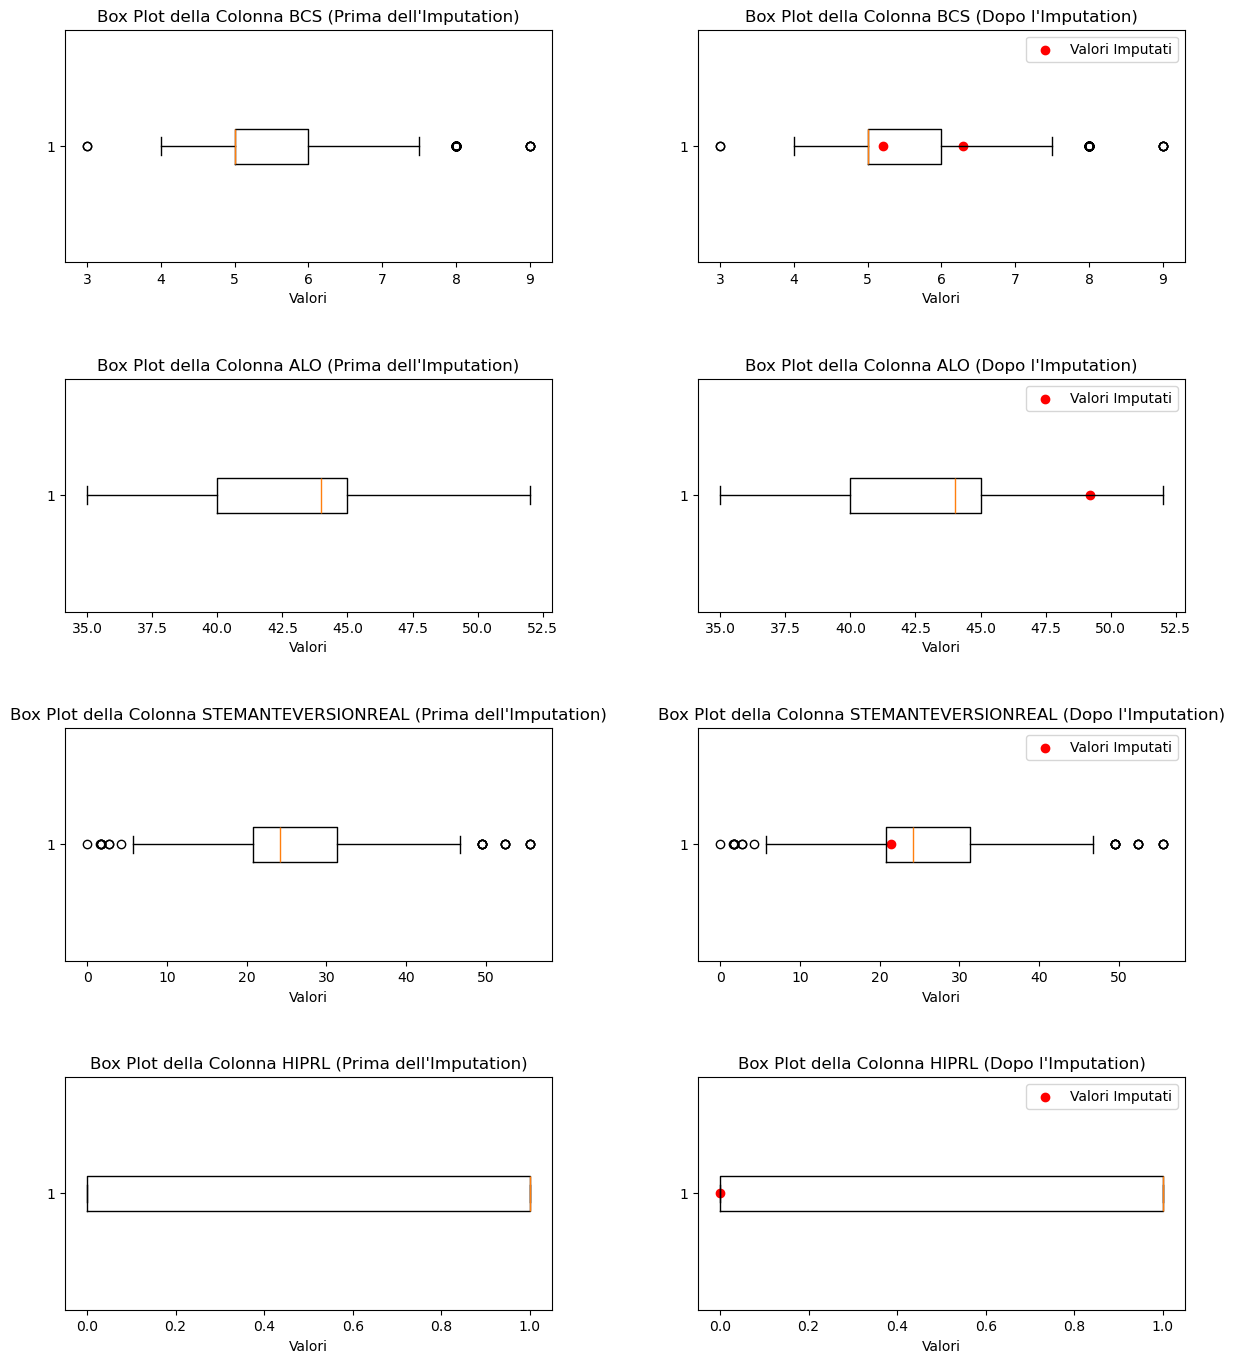

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(14, 16))

new_values_bcs = df[df_original['BCS'].isna()]['BCS']

# Box plot e scatter plot per la colonna BCS
plt.subplot(4, 2, 1)
plt.boxplot(df_original['BCS'].dropna(), vert=False)
plt.title('Box Plot della Colonna BCS (Prima dell\'Imputation)')
plt.xlabel('Valori')

plt.subplot(4, 2, 2)
plt.boxplot(df['BCS'], vert=False)
plt.scatter(new_values_bcs, [1]*len(new_values_bcs), color='red', label='Valori Imputati')
plt.title('Box Plot della Colonna BCS (Dopo l\'Imputation)')
plt.xlabel('Valori')
plt.legend()

new_values_alo = df[df_original['ALO'].isna()]['ALO']

# Box plot e scatter plot per la colonna ALO
plt.subplot(4, 2, 3)
plt.boxplot(df_original['ALO'].dropna(), vert=False)
plt.title('Box Plot della Colonna ALO (Prima dell\'Imputation)')
plt.xlabel('Valori')

plt.subplot(4, 2, 4)
plt.boxplot(df['ALO'], vert=False)
plt.scatter(new_values_alo, [1]*len(new_values_alo), color='red', label='Valori Imputati')
plt.title('Box Plot della Colonna ALO (Dopo l\'Imputation)')
plt.xlabel('Valori')
plt.legend()

new_values_STEMANTEVERSIONREAL = df[df_original['STEMANTEVERSIONREAL'].isna()]['STEMANTEVERSIONREAL']

# Box plot e scatter plot per la colonna STEMANTEVERSIONREAL
plt.subplot(4, 2, 5)
plt.boxplot(df_original['STEMANTEVERSIONREAL'].dropna(), vert=False)
plt.title('Box Plot della Colonna STEMANTEVERSIONREAL (Prima dell\'Imputation)')
plt.xlabel('Valori')

plt.subplot(4, 2, 6)
plt.boxplot(df['STEMANTEVERSIONREAL'], vert=False)
plt.scatter(new_values_STEMANTEVERSIONREAL, [1]*len(new_values_STEMANTEVERSIONREAL), color='red', label='Valori Imputati')
plt.title('Box Plot della Colonna STEMANTEVERSIONREAL (Dopo l\'Imputation)')
plt.xlabel('Valori')
plt.legend()

new_values_HIPRL = df[df_original['HIPRL'].isna()]['HIPRL']

# Box plot e scatter plot per la colonna HIPRL
plt.subplot(4, 2, 7)
plt.boxplot(df_original['HIPRL'].dropna(), vert=False)
plt.title('Box Plot della Colonna HIPRL (Prima dell\'Imputation)')
plt.xlabel('Valori')

plt.subplot(4, 2, 8)
plt.boxplot(df['HIPRL'], vert=False)
plt.scatter(new_values_HIPRL, [1]*len(new_values_HIPRL), color='red', label='Valori Imputati')
plt.title('Box Plot della Colonna HIPRL (Dopo l\'Imputation)')
plt.xlabel('Valori')
plt.legend()

# Aggiungere spazio tra i grafici e ai bordi
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3, left=0.1, right=0.9, top=0.9, bottom=0.1)  # Aggiungere spazio tra i grafici e ai bordi

plt.show()

In [9]:
dataset = dataset_imputed

In [10]:
dataset.isna().sum()

CASE_ID                     0
BREED                       0
GENDER_01                   0
AGEATSURGERYmo              0
BODYWEIGHTKG                0
Taglia                      0
BCS                         0
INDICATIONFORTHR            0
HIPRL                       0
YEAR                        0
n_luxation                  0
GENERATION                  0
STEMSIZE                    0
CUPSIZE                     0
NECKSIZE                    0
HEADSIZE                    0
ALO                         0
CUPRETROVERSION             0
STEMANTEVERSIONREAL         0
RECTUSFEMORISM.RELEASE      0
first_lux_days_after_thr    0
DIRECTION                   0
LUX_01                      0
LUX_CR                      0
BSC                         0
dtype: int64

In [12]:
# Definizione di X e y

# insieme di predittori
feature_cols = ['CASE_ID', 'BREED', 'GENDER_01', 'AGEATSURGERYmo', 'BODYWEIGHTKG', 'Taglia', 'BCS', 'INDICATIONFORTHR', 'HIPRL', 
                'YEAR', 'GENERATION', 'STEMSIZE', 'CUPSIZE', 'NECKSIZE', 'HEADSIZE', 'ALO', 'CUPRETROVERSION', 'STEMANTEVERSIONREAL', 
                'RECTUSFEMORISM.RELEASE', 'LUX_CR', 'n_luxation', 'DIRECTION', 'first_lux_days_after_thr']
X = dataset[feature_cols]

# variabile di risposta, è una variabile binaria
y = dataset['LUX_01']

In [17]:
dataset = func.oversampling(X, y)

In [18]:
dataset = dataset.sample(frac=1, random_state=42)

In [19]:
dataset = func.drop_cols(dataset)

In [20]:
feature_cols = ['BREED', 'GENDER_01', 'AGEATSURGERYmo', 'BODYWEIGHTKG', 'Taglia', 'BCS', 'INDICATIONFORTHR', 'HIPRL', 
                'YEAR', 'GENERATION', 'STEMSIZE', 'CUPSIZE', 'NECKSIZE', 'HEADSIZE', 'ALO', 'CUPRETROVERSION', 'STEMANTEVERSIONREAL', 
                'RECTUSFEMORISM.RELEASE', 'LUX_CR']

X = dataset[feature_cols]
y = dataset['target']

# la feature LUX_01 è stata cambiata in target dopo l'oversampling

### Regressione logistica sulla feature target

In [21]:
model = models.logistic_regression_model(X, y)

Report di classificazione:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       911
           1       0.73      0.80      0.76       923

    accuracy                           0.75      1834
   macro avg       0.75      0.75      0.75      1834
weighted avg       0.75      0.75      0.75      1834



### Regressione logistica con cross validation

In [22]:
model = models.logistic_regression_cv_model(X, y, cv=5)

Report di classificazione:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       911
           1       0.73      0.80      0.77       923

    accuracy                           0.75      1834
   macro avg       0.76      0.75      0.75      1834
weighted avg       0.76      0.75      0.75      1834



### Regressione logistica con grid search cv

In [23]:
param_grid = {
    'C': [0.01, 0.1, 1]
}

model = models.logistic_regression_gridsearchcv_model(X=X,
                                                      y=y,
                                                      param_grid=param_grid,
                                                      cv=5,
                                                      scoring='accuracy')

Report di classificazione:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       911
           1       0.73      0.80      0.77       923

    accuracy                           0.75      1834
   macro avg       0.76      0.75      0.75      1834
weighted avg       0.76      0.75      0.75      1834

Migliori parametri: {'C': 1}


### Albero di decisione

In [24]:
model = models.decision_tree_model(X=X,
                                   y=y,
                                   max_depth=15)

Report di classificazione:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       911
           1       0.92      0.94      0.93       923

    accuracy                           0.93      1834
   macro avg       0.93      0.93      0.93      1834
weighted avg       0.93      0.93      0.93      1834



### Albero di decisione con grid search cv

In [25]:
param_grid = {
    'max_depth': [5, 10, 15]
}

model = models.decision_tree_gridsearchcv_model(X=X,
                                                y=y,
                                                param_grid=param_grid,
                                                cv=10,
                                                scoring='accuracy')

Report di classificazione:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       911
           1       0.92      0.94      0.93       923

    accuracy                           0.93      1834
   macro avg       0.93      0.93      0.93      1834
weighted avg       0.93      0.93      0.93      1834

Migliori parametri: {'max_depth': 15}


### Random forest

In [26]:
model = models.random_forest_model(X=X,
                                   y=y,
                                   n_estimators=10,
                                   max_depth=10)

Report di classificazione:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       911
           1       0.94      0.94      0.94       923

    accuracy                           0.94      1834
   macro avg       0.94      0.94      0.94      1834
weighted avg       0.94      0.94      0.94      1834



### Random forest con grid search cv

In [27]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_estimators': [7, 9, 11, 13]
}

model = models.random_forest_gridsearchcv_model(X=X,
                                                y=y,
                                                param_grid=param_grid,
                                                cv=10,
                                                scoring='accuracy')

Report di classificazione:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       911
           1       0.97      0.93      0.95       923

    accuracy                           0.95      1834
   macro avg       0.95      0.95      0.95      1834
weighted avg       0.95      0.95      0.95      1834

Migliori parametri: {'max_depth': 15, 'n_estimators': 11}


Come per i modelli allenati senza l'imputation, i risultati ottenuti sono praticamente identici, al massimo cambia 1 o 2 livelli percentuali.

Come per i modelli allenati senza l'imputation, il modello di random forest risulta essere il migliore.